# pysgrid

In [1]:
from netCDF4 import Dataset

url = ('http://geoport.whoi.edu/thredds/dodsC/clay/usgs/users/'
       'jcwarner/Projects/Sandy/triple_nest/00_dir_NYB05.ncml')

nc = Dataset(url)

The pysgrid object can be instantiated from a `netCDF4-python` object or the file/URL.

In [2]:
import pysgrid

sgrid = pysgrid.from_nc_dataset(nc)

The `sgrid` object knows about the center of the grid and prepare a slicing object that can be used to get the data at the center of the grid.

In [3]:
sgrid.u.center_slicing

(slice(None, None, None),
 slice(None, None, None),
 slice(1, -1, None),
 slice(None, None, None))

In [4]:
sgrid.v.center_slicing

(slice(None, None, None),
 slice(None, None, None),
 slice(None, None, None),
 slice(1, -1, None))

Let's get some data. (Using integer indexes for convenience.)

In [5]:
time_idx = 120
vertical_idx = 0

u = nc['u'][time_idx, vertical_idx, sgrid.u.center_slicing[-2], sgrid.u.center_slicing[-1]]
v = nc['v'][time_idx, vertical_idx, sgrid.v.center_slicing[-2], sgrid.v.center_slicing[-1]]

The raw API is just that: an interpretation of the SGRID conventions that translate to a center slicing object.
It does not look like much, but anyone familiar with staggered grids models know the amount of code that goes into performing that slice.

The API is meant to be used by higher level tools like `iris` and `xray` where plotting/slicing would be done automatically.

However, `pysgrid` **does** bring some convenience processing methods like:

- avg_to_cell_center

In [6]:
from pysgrid.processing_2d import avg_to_cell_center

u = avg_to_cell_center(u, sgrid.u.center_axis)
v = avg_to_cell_center(v, sgrid.v.center_axis)

- rotate_vectors

In [7]:
from pysgrid.processing_2d import rotate_vectors

angles = nc.variables[sgrid.angle.variable][sgrid.angle.center_slicing]
u, v = rotate_vectors(u, v, angles)

- vector_sum

In [8]:
from pysgrid.processing_2d import vector_sum

speed = vector_sum(u, v)

C:\Users\rsignell\AppData\Local\Continuum\Anaconda2\envs\IOOS\lib\site-packages\pysgrid\processing_2d.py:22: RuntimeWarning: invalid value encountered in sqrt
  vector_sum = np.sqrt(x_arr**2 + y_arr**2)


We need to get the grid cell centers before plotting.
A high level object could use pysgrid's API to get the cell centers and its coordinates variable names.

In [9]:
grid_cell_centers = sgrid.centers

lon_var_name, lat_var_name = sgrid.face_coordinates

sg_lon = getattr(sgrid, lon_var_name)
sg_lat = getattr(sgrid, lat_var_name)

And then perform the same center slicing we did for the variables.

In [10]:
lon = grid_cell_centers[..., 0][sg_lon.center_slicing]
lat = grid_cell_centers[..., 1][sg_lat.center_slicing]

In [11]:
a =sg_lon.center_slicing[0]
a

slice(1, -1, None)

Now that we have data and coordinates at the grid center we can finally plot the data.

In [12]:
import numpy as np
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


def make_map(projection=ccrs.PlateCarree(), figsize=(9, 9)):
    fig, ax = plt.subplots(figsize=figsize,
                           subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

Subset for better visualization.

In [13]:
sub = 4

lon = lon[::sub, ::sub]
lat = lat[::sub, ::sub]
u, v = u[::sub, ::sub], v[::sub, ::sub]
speed = speed[::sub, ::sub]

Extend bounds for centered pcolor.

In [14]:
def is_monotonically_increasing(arr):
    return [x < y for x, y in zip(arr, arr[1:])]

def is_monotonically_decreasing(arr):
    return [x > y for x, y in zip(arr, arr[1:])]


def is_monotonic(arr):
    return (np.all(is_monotonically_increasing(arr)) or
            np.all(is_monotonically_decreasing(arr)))

def extent_bounds(arr, bound_position=0.5, axis=0):
    if not is_monotonic(arr):
        msg = "Array {!r} must be monotonic to guess bounds".format
        raise ValueError(msg(arr))
    
    x = arr.copy()
    x = np.c_[x[:, 0], (bound_position * (x[:, :-1] + x[:, 1:])), x[:, -1]]
    x = np.r_[x[0, :][None, ...], (bound_position * (x[:-1, :] + x[1:, :])), x[-1, :][None, ...]]
        
    return x


x = extent_bounds(lon)
y = extent_bounds(lat)

<IPython.core.display.Javascript object>


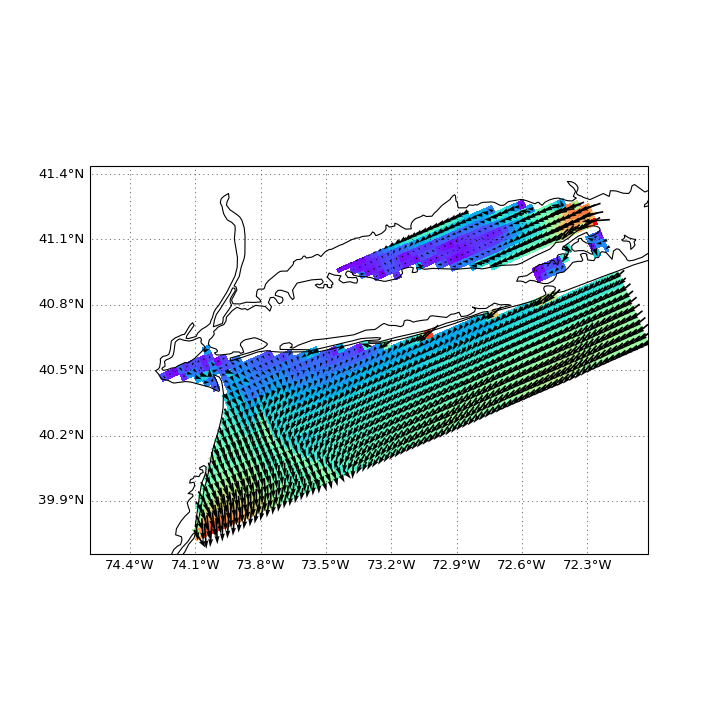

In [15]:
%matplotlib notebook

scale = 0.06

fig, ax = make_map()

kw = dict(scale=1.0/scale, pivot='middle', width=0.003, color='black')
q = plt.quiver(lon, lat, u, v, zorder=2, **kw)

cs = plt.pcolormesh(x, y, speed, zorder=1, cmap=plt.cm.rainbow)

_ = ax.coastlines('10m')